# Quick start

Cog Worker is a simple library that helps you write scalable
analysis on Cloud Optimized Geotiffs (COGs).

A simple cog_worker script looks like the following.

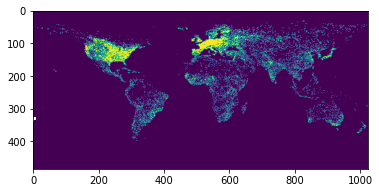

<AxesSubplot:>

In [1]:
from rasterio.plot import show
from cog_worker import Manager

def my_analysis(worker):
    arr = worker.read('roads_cog.tif')
    return arr

manager = Manager(proj='wgs84', scale=0.083333)
arr, bbox = manager.preview(my_analysis)
show(arr)

## Writing a cog_worker script.

### 1. Define an analysis function that recieves a cog_worker.Worker as the first parameter.

In [2]:
from cog_worker import Worker, Manager
import numpy as np

# Define an analysis function to read and process COG data sources
def MyAnalysis(worker: Worker) -> np.ndarray:

    # 1. Read a COG (reprojecting, resampling and clipping as necessary)
    array: np.ndarray = worker.read('roads_cog.tif')

    # 2. Work on the array    
    # ...

    # 3. Return (or post to blob storage etc.)
    return array

### 2. Run your analysis in different scales and projections

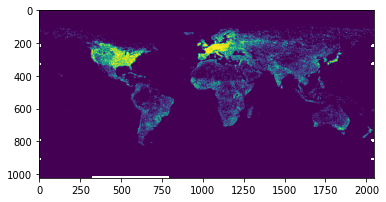

(-180.0, -34.99950000000001, -55.00049999999999, 90.0)
(-180.0, -90.0, -55.00049999999999, -34.99950000000001)
(-55.00049999999999, -34.99950000000001, 69.99900000000002, 90.0)
(-55.00049999999999, -90.0, 69.99900000000002, -34.99950000000001)
(69.99900000000002, -34.99950000000001, 180.0, 90.0)
(69.99900000000002, -90.0, 180.0, -34.99950000000001)


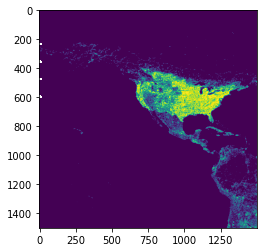

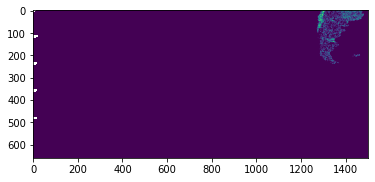

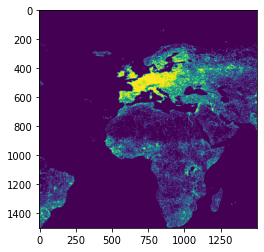

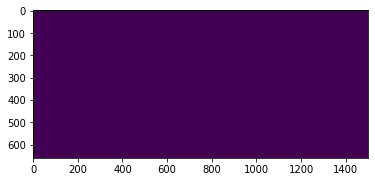

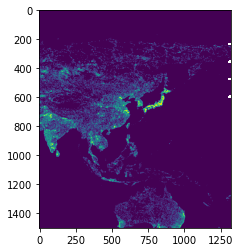

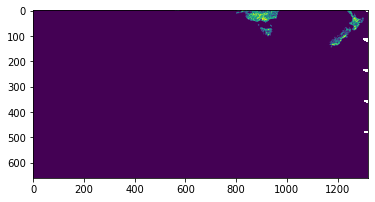

{'proj': '+proj=longlat +datum=WGS84 +no_defs', 'scale': 0.083333, 'buffer': 128, 'proj_bounds': (-180.0, -34.99950000000001, -55.00049999999999, 90.0)}
{'proj': '+proj=longlat +datum=WGS84 +no_defs', 'scale': 0.083333, 'buffer': 128, 'proj_bounds': (-180.0, -90.0, -55.00049999999999, -34.99950000000001)}
{'proj': '+proj=longlat +datum=WGS84 +no_defs', 'scale': 0.083333, 'buffer': 128, 'proj_bounds': (-55.00049999999999, -34.99950000000001, 69.99900000000002, 90.0)}
{'proj': '+proj=longlat +datum=WGS84 +no_defs', 'scale': 0.083333, 'buffer': 128, 'proj_bounds': (-55.00049999999999, -90.0, 69.99900000000002, -34.99950000000001)}
{'proj': '+proj=longlat +datum=WGS84 +no_defs', 'scale': 0.083333, 'buffer': 128, 'proj_bounds': (69.99900000000002, -34.99950000000001, 180.0, 90.0)}
{'proj': '+proj=longlat +datum=WGS84 +no_defs', 'scale': 0.083333, 'buffer': 128, 'proj_bounds': (69.99900000000002, -90.0, 180.0, -34.99950000000001)}


In [3]:
import rasterio as rio

# Run your analysis using a cog_worker.Manager which handles chunking
manager = Manager(
    proj = 'wgs84',       # any pyproj string
    scale = 0.083333,  # in projection units (degrees or meters)
    bounds = (-180, -90, 180, 90),
    buffer = 128          # buffer pixels when chunking analysis
)

# preview analysis
arr, bbox = manager.preview(my_analysis, max_size=2048)
rio.plot.show(arr)

# preview analysis chunks
for bbox in manager.chunks(chunksize=1500):
    print(bbox)

# execute analysis chunks sequentially
for arr, bbox in manager.chunk_execute(my_analysis, chunksize=1500):
    rio.plot.show(arr)

# generate job execution parameters
for params in manager.chunk_params(chunksize=1500):
    print(params)

### 3. Write scale-dependent functions

In [4]:
import scipy
from cog_worker import Worker
import numpy as np

def focal_mean(
    worker: Worker, 
    kernel_radius: float = 1000 # radius in projection units (meters)
) -> np.ndarray:

    array: np.ndarray = worker.read('roads_cog.tif')

    # Access the pixel size at worker.scale
    kernel_size = kernel_radius * 2 / worker.scale
    array = scipy.ndimage.uniform_filter(array, kernel_size)

    return array

### 4. Chunk your analysis and run it in a dask cluster

/usr/local/homebrew/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61791 instead
  warnings.warn(


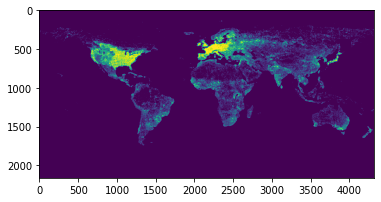

In [6]:
from cog_worker.distributed import DaskManager
from dask.distributed import LocalCluster, Client

# Set up a Manager with that connects to a Dask cluster
cluster = LocalCluster()
client = Client(cluster)
distributed_manager = DaskManager(
    client,
    proj = 'wgs84',
    scale = 0.083333,
    bounds = (-180, -90, 180, 90),
    buffer = 128
)

# Execute in worker pool and save chunks to disk as they complete.
distributed_manager.chunk_save('output.tif', my_analysis, chunksize=2048)

with rio.open('output.tif') as src:
    show(src.read())